# Tarjeta de datos 5

Hipótesis 5: *¿Qué cantidad de placas solares fotovoltaicas se necesitarían instalar para abastecer el consumo eléctrico de los hogares de Castilla-La Mancha en el año 2028?*

Esta hipótesis es interesante para conocer cuál es el verdadero potencial y la rentabilidad de uno de los dispositivos de aprovechamiento de energía renovables más comunes y utilizados actualmente, las placas solares fotovoltaicas. 

El objetivo es obtener una tarjeta de datos con la siguente estructura:

| Provincia   | Producción eléctrica anual (MWh) | Consumo (MWh) Año X | Consumo (MWh) Año X+1 | ... |
|-------------|----------------------------------|---------------------|-----------------------|-----|
| Albacete    |                                  |                     |                       |     |
| Ciudad Real |                                  |                     |                       |     |
| Cuenca      |                                  |                     |                       |     |
| Guadalajara |                                  |                     |                       |     |
| Toledo      |                                  |                     |                       |     |


Así, con esta tarjeta, sabiendo el histórico de consumo eléctrico de los hogares de Castilla-La Mancha, se podrá calcular el consumo para un año concreto. Además, con la producción anual eléctrica de energía que ya tiene en cuenta la meteorología de cada zona y la geografía, se podrá calcular cuántas placas solares fotovoltaicas se necesitarían instalar para abastecer el consumo eléctrico de los hogares.


--------------------------------------------

## Preparación del entorno

In [34]:
import pandas as pd
import os 

SILVER_DATA_PATH = os.path.join("..", "data/silver/")
GOLD_DATA_PATH = os.path.join("..", "data/gold/")

In [35]:
PROVINCIAS = ['Albacete', 'Ciudad Real', 'Cuenca', 'Guadalajara', 'Toledo']

## Datos

Primero, cargamos los datasets que vamos a necesitar para realizar el análisis:
* El dataset `consumo_electrico_clm.csv` que contiene el histórico del consumo eléctrico de Castilla-La Mancha desde el 2000 al 2023.
* El dataset de `produccion_lugar.csv` que contiene la producción teórica de un metro cuadrado de placa solar fotovoltaica con un rendimiento del 100%.

In [36]:
consumo_df = pd.read_csv(os.path.join(SILVER_DATA_PATH, "consumo_electrico_clm.csv"), sep=";", encoding="latin1")
consumo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   288 non-null    int64  
 1   Año          288 non-null    int64  
 2   Mes          288 non-null    object 
 3   Albacete     288 non-null    float64
 4   Ciudad Real  288 non-null    float64
 5   Cuenca       288 non-null    float64
 6   Guadalajara  288 non-null    float64
 7   Toledo       288 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 18.1+ KB


In [37]:
produccion_df = pd.read_csv(os.path.join(SILVER_DATA_PATH, "produccion_lugar.csv"), sep=";", encoding="latin1")
produccion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Provincia     516 non-null    object 
 1   Potencia kWh  516 non-null    float64
 2   Mes           516 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.2+ KB


## Procesamiento

### consumo_df

Con los datos de `consumo_df` queremos predecir el consumo eléctrico de Castilla-La Mancha en el año 2028. Para ello, vamos a realizar una regresión con los datos de consumo eléctrico de los años 2000 al 2023.

Los datos de `consumo_df` son los siguientes:

| Columna | Descripción | Unidades | Tipo de dato |
| --- | --- | --- | ---- |
| Año | Año de la observación |  | int64 |
| Mes | Nombre del mes de la observación |  | object |
| Albacete | Consumo eléctrico de la provincia de Albacete | MWh | float64 |
| Ciudad Real | Consumo eléctrico de la provincia de Ciudad Real | MWh | float64 |
| Cuenca | Consumo eléctrico de la provincia de Cuenca | MWh | float64 |
| Guadalajara | Consumo eléctrico de la provincia de Guadalajara | MWh | float64 |
| Toledo | Consumo eléctrico de la provincia de Toledo | MWh | float64 |

In [38]:
consumo_df.drop(columns=["Unnamed: 0"], inplace=True)
consumo_df.head()

,Año,Mes,Albacete,Ciudad Real,Cuenca,Guadalajara,Toledo
0,2000,Enero,44382.485,84055.668,20737.929,35525.741,92130.972
1,2000,Febrero,48189.879,38999.807,18601.058,18565.008,84443.252
2,2000,Marzo,43310.071,75765.527,19314.888,31448.724,84121.421
3,2000,Abril,28232.132,23348.460,11482.412,11867.874,50376.899
4,2000,Mayo,35245.173,58877.308,15737.450,26967.290,62182.985


Se transforma la fecha a un formato datetime para establecerla como índice y poder representarla en un gráfico.

In [39]:
encode_mes = {}
for i, mes in enumerate(consumo_df["Mes"].unique()):
    encode_mes[mes] = i + 1

# Reemplazar los nombres de los meses por números
consumo_df["Mes"] = consumo_df["Mes"].replace(encode_mes)

C:\Users\elena\AppData\Local\Temp\ipykernel_22024\2325877145.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  consumo_df["Mes"] = consumo_df["Mes"].replace(encode_mes)


In [40]:
# Combinar Año y Mes en una columna Fecha
consumo_df.rename(columns={'Año': 'year', 'Mes': 'month'}, inplace=True)
consumo_df["Fecha"] = pd.to_datetime(consumo_df[['month', 'year']].assign(day=1), yearfirst=False)

consumo_df.drop(columns=["year", "month"], inplace=True)
# Establecer la fecha como índice
consumo_df.set_index("Fecha", inplace=True)

Se realizará un análisis exploratorio de los datos mediante un gráfico de líneas.
* Albacete con el color azul
* Ciudad Real con el color naranja
* Cuenca con el color verde
* Guadalajara con el color rojo
* Toledo con el color morado


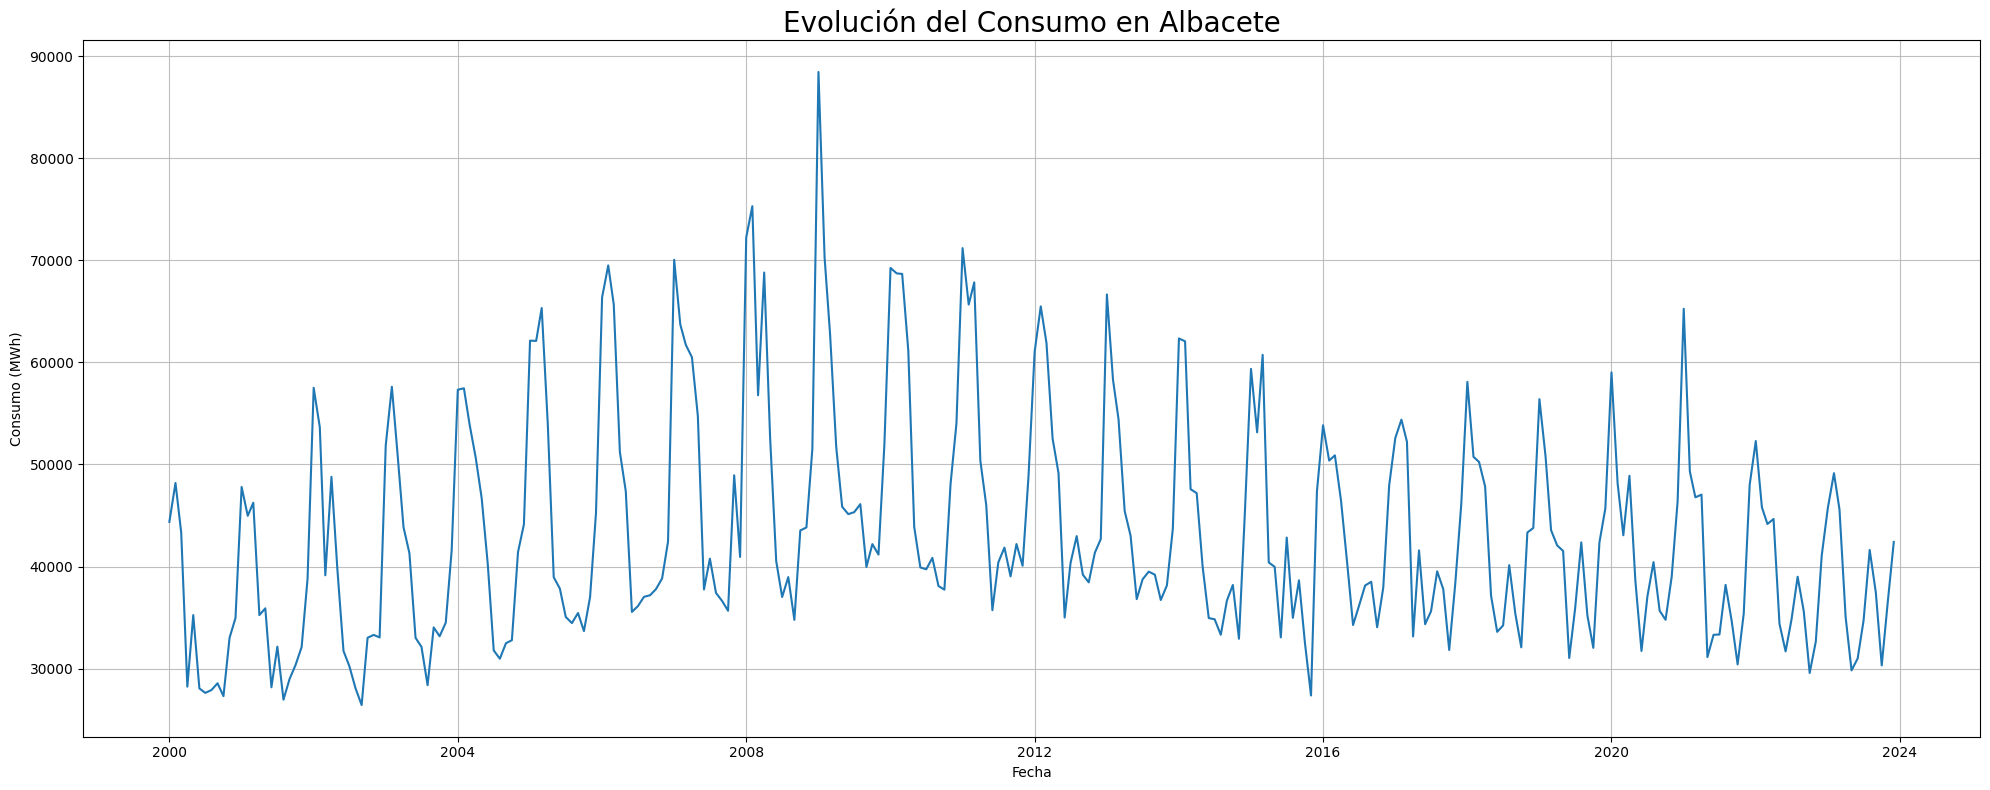

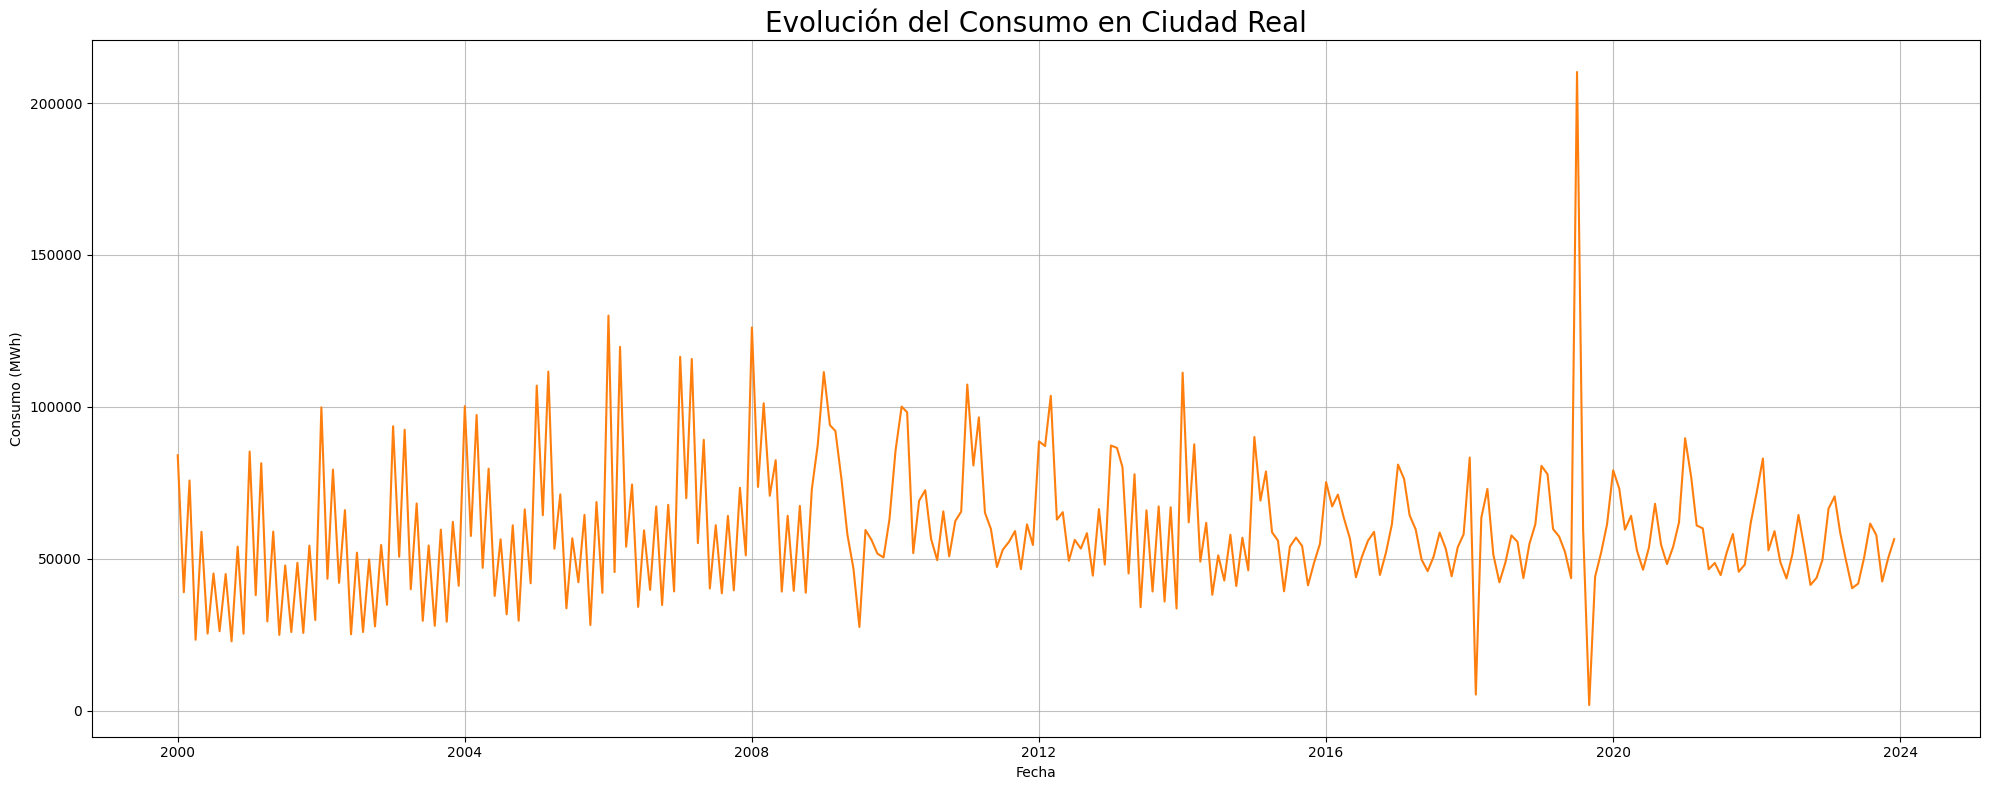

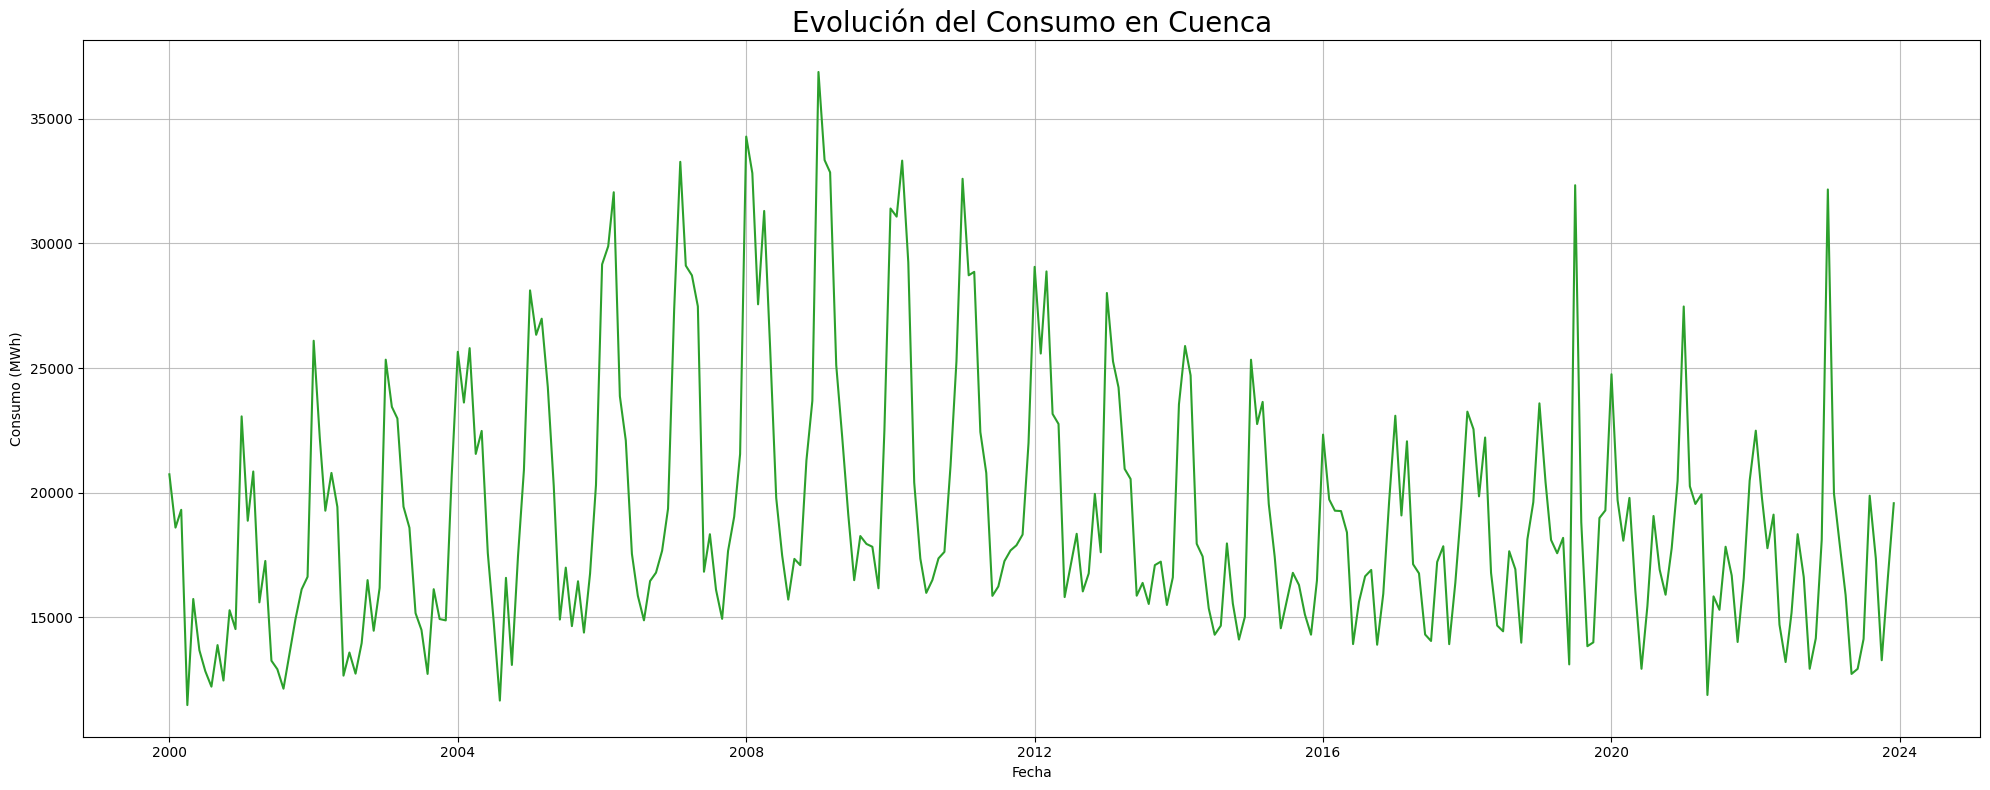

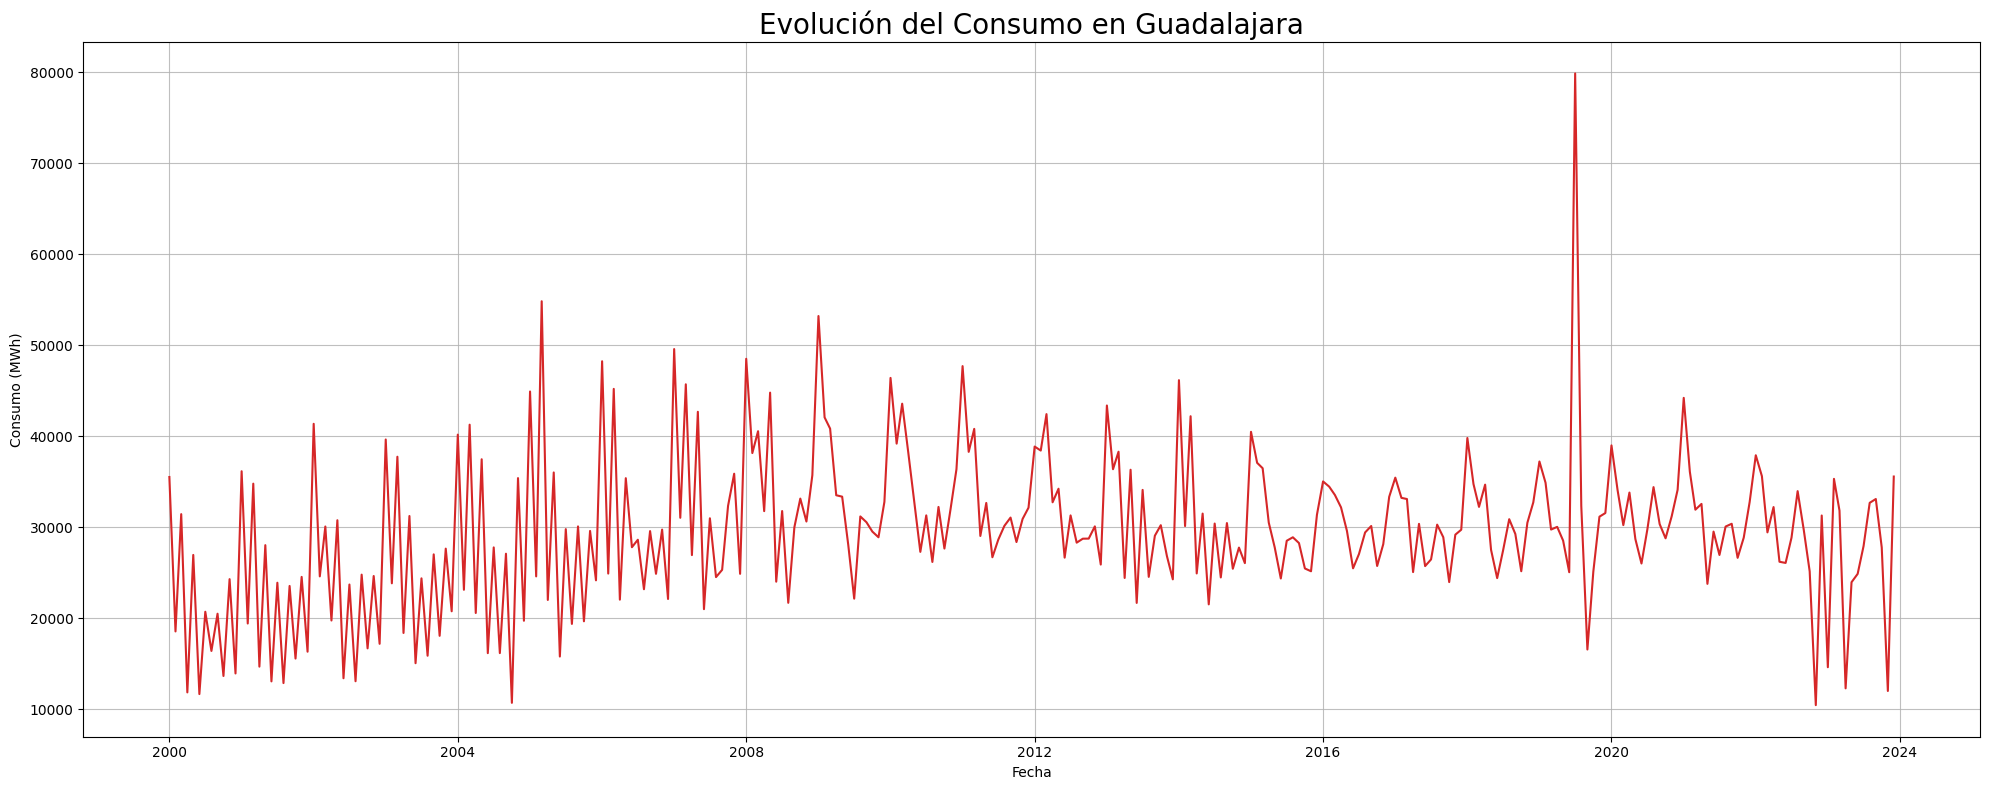

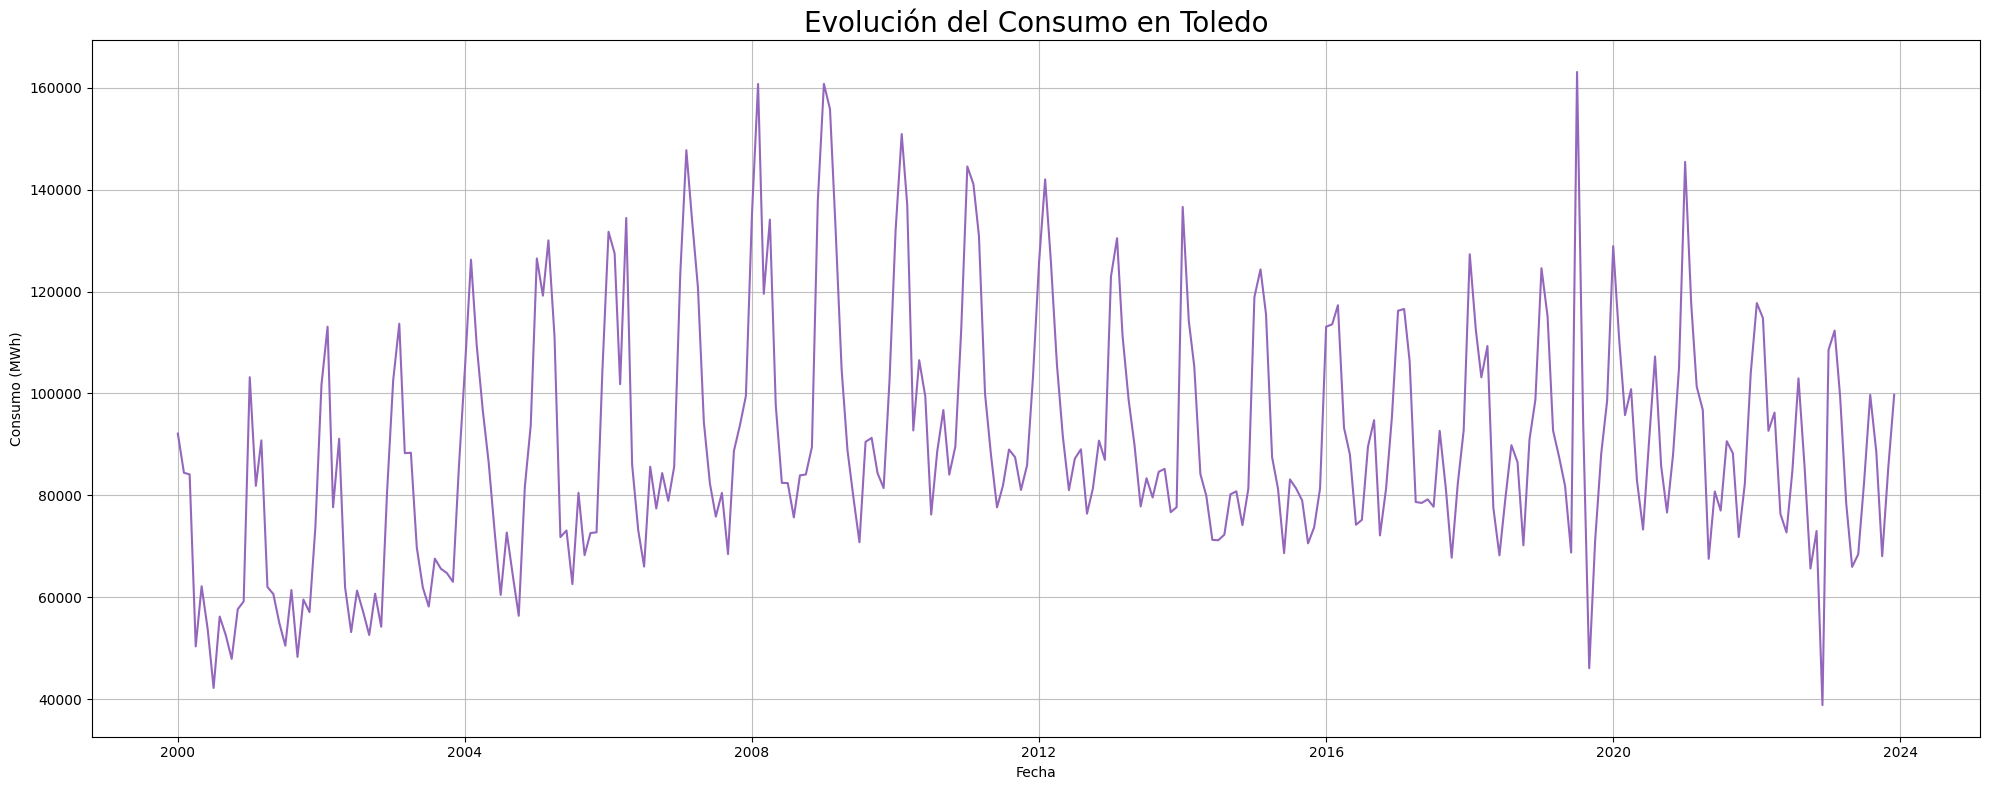

In [41]:
from tkinter import font
import matplotlib.pyplot as plt

# Vector de colores para las provincias
colors = plt.cm.tab10(range(len(PROVINCIAS)))

# Crear un gráfico de lineas para mostrar fecha vs consumo para cada provincia
for provincia, color in zip(PROVINCIAS, colors):
    plt.figure(figsize=(20, 8))
    plt.plot(consumo_df.index, consumo_df[provincia], color=color)
    plt.title(f"Evolución del Consumo en {provincia}", fontsize=20)
    plt.xlabel("Fecha")
    plt.ylabel("Consumo (MWh)")
    plt.grid(alpha = 0.8)
    plt.tight_layout()
    plt.show()


In [42]:
consumo_df.describe()

,Albacete,Ciudad Real,Cuenca,Guadalajara,Toledo
count,288.000000,288.000000,288.000000,288.000000,288.000000
mean,43413.073559,59321.293816,19223.305767,29577.703479,90274.761778
std,10948.805478,22381.859713,5090.229448,8384.973505,23548.776700
min,26428.724000,1851.570000,11482.412000,10467.989000,38868.725000
25%,35235.139500,45704.578000,15795.331250,24894.266500,74973.855500
50%,40676.876000,56427.021000,17803.202500,29603.817000,85848.855500
75%,48904.378250,67839.116500,21665.818750,33531.456500,103164.337250
max,88453.192000,210209.615000,36876.639000,79861.303000,163075.636000


A continuación se muestra la gráfica de consumo para un año en una provincia, en este caso Albacete en el año 2000.

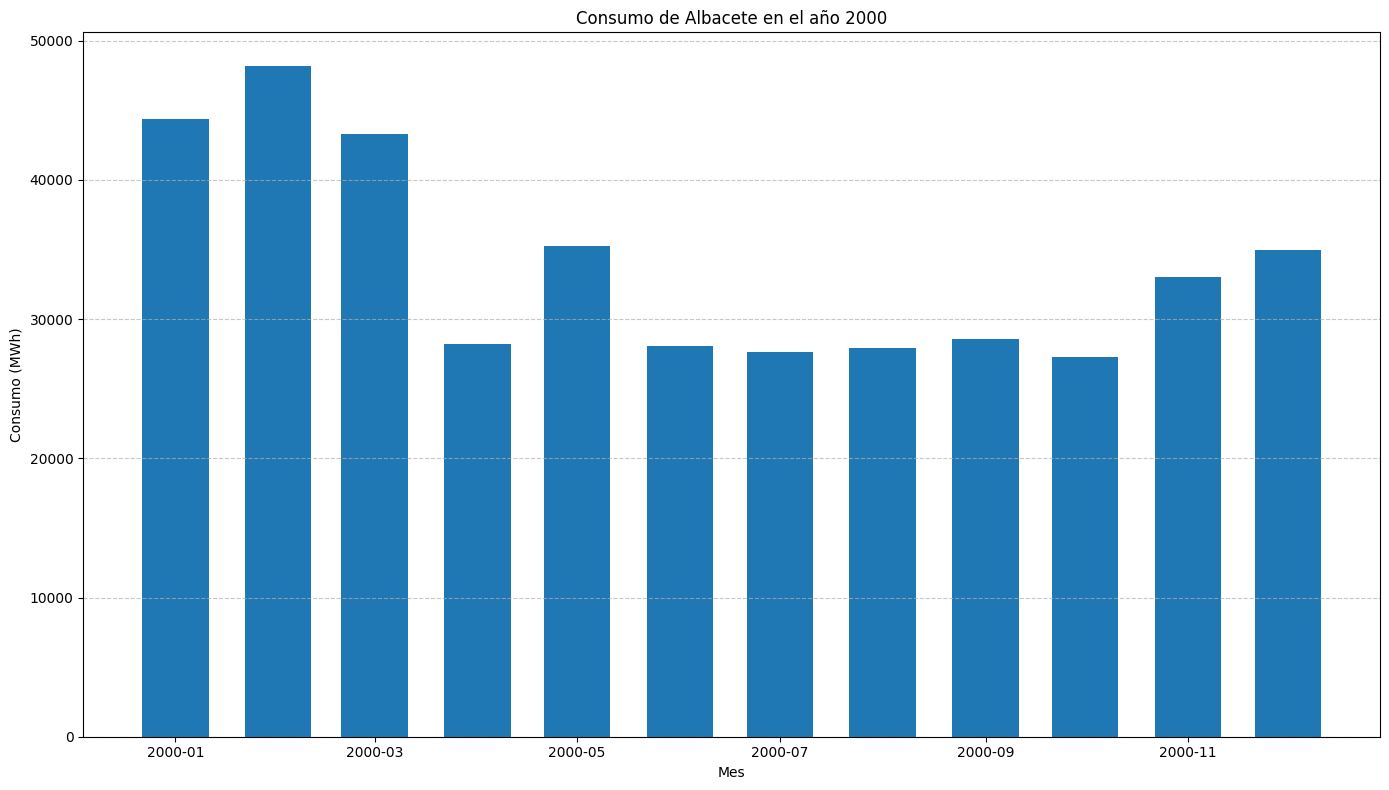

In [ ]:
albacete_2000 = consumo_df[:12]["Albacete"]
plt.figure(figsize=(14, 8))
plt.bar(albacete_2000.index, albacete_2000, width=20)
plt.title("Consumo de Albacete en el año 2000")
plt.xlabel("Mes")
plt.ylabel("Consumo (MWh)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Con este análisis exploratorio inicial, se observa que los datos presentan una gran variación y además hay valores atípicos, como en Ciudad Real y Guadalajara poco antes del año 2020. 

La gran variación de los datos se debe a su granularidad a nivel mensual. En los meses más fríos el consumo es mayor que en los meses más cálidos y ello, sumado a la variación entre años, hace difícil establecer una tendencia clara. Por ello, vamos a agrupar los datos por año para obtener una mejor predicción.

In [53]:
consumo_anual = consumo_df.index.year
consumo_anual = consumo_df.groupby(consumo_anual).sum()
consumo_anual.head(2)

,Albacete,Ciudad Real,Cuenca,Guadalajara,Toledo
Fecha,,,,,
2000,406793.894,524903.411,180793.219,245641.667,742811.869
2001,427716.484,550174.074,195232.524,263052.687,804171.596


A continuación, se muestra de nuevo la gráfica del consumo por años.

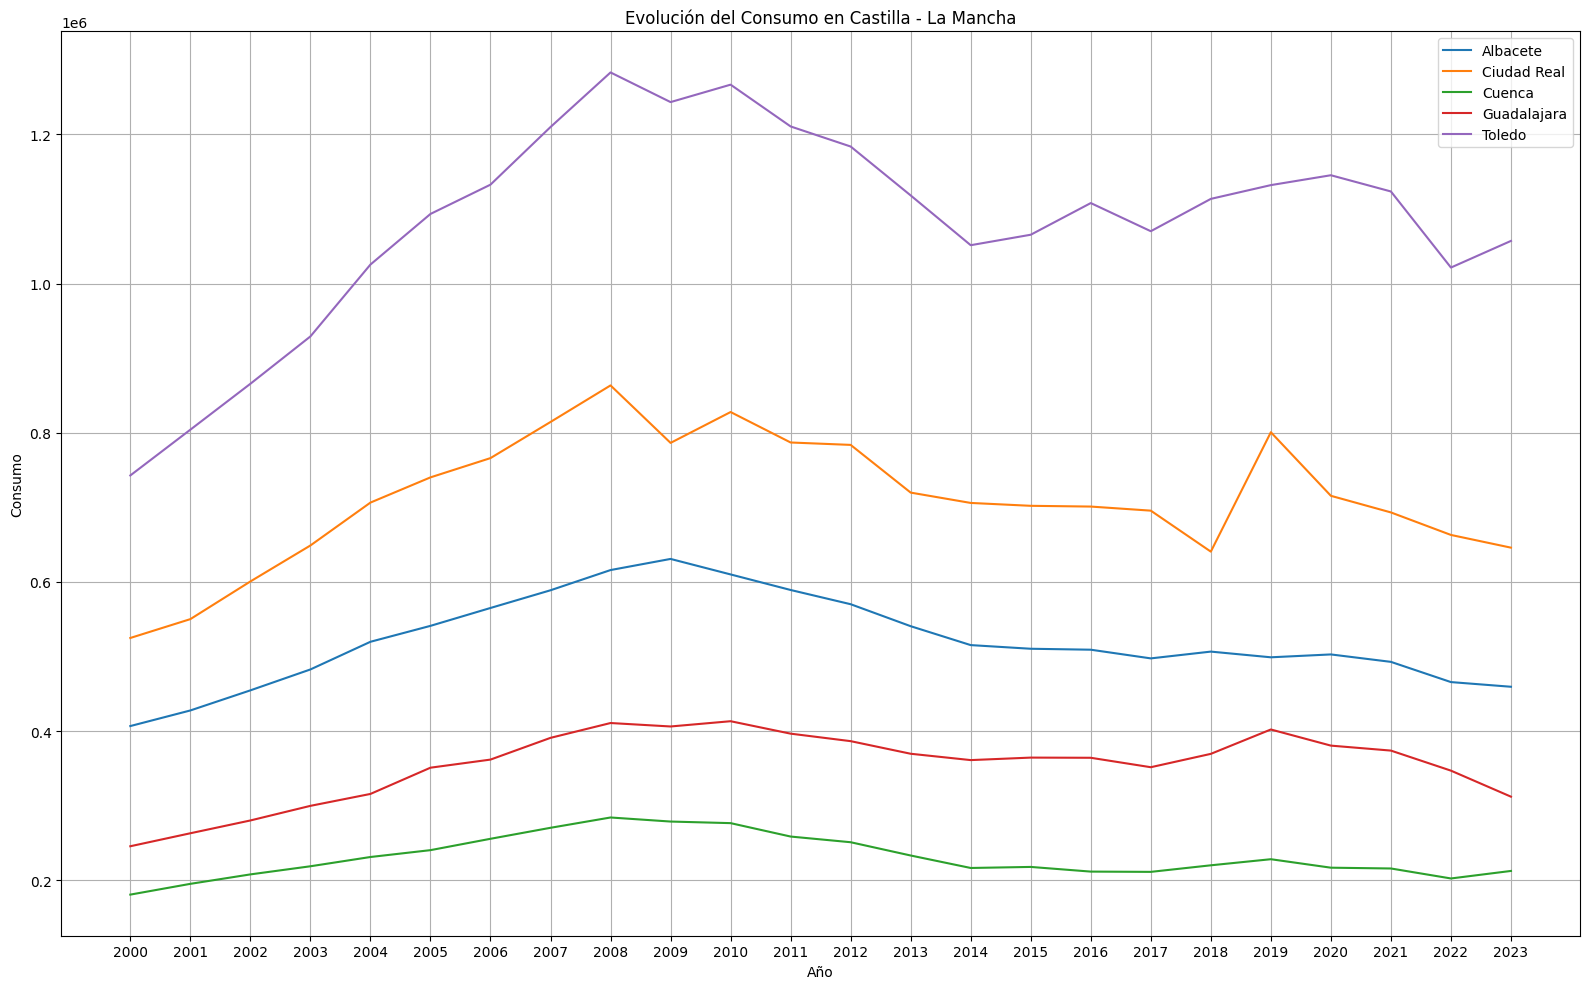

In [54]:
import matplotlib.pyplot as plt

# Colores 
colors = plt.cm.tab10(range(len(PROVINCIAS)))

# Crear un gráfico con todas las provincias juntas
plt.figure(figsize=(16, 10))
for provincia, color in zip(PROVINCIAS, colors):
    plt.plot(consumo_anual.index, consumo_anual[provincia], color=color, label=provincia)
    plt.xticks(consumo_anual.index)
    
plt.title(f"Evolución del Consumo en Castilla - La Mancha")
plt.xlabel("Año")
plt.ylabel("Consumo")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Los datos muestran una tendencia creciente desde el año 2000 hasta el año 2009 aproximaadamente, a partir de entonces disminuye hasta el año 2014, en el que la mayoría de las provincias se mantienen o aumentan. Por esta razón, y para mejorar la precisión de la predicción, se seleccionarán solo los datos del 2014 a 2023.

In [56]:
consumo_anual = consumo_anual[consumo_anual.index > 2013]

Se rota la tabla para que las provincias sean los índices y los años las columnas.

In [57]:
consumo_anual = consumo_anual.transpose()
consumo_anual.head()

Fecha,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Albacete,515346.771,510449.350,509172.021,497531.889,506629.073,498994.018,502837.096,492873.312,465755.760,459494.649
Ciudad Real,705967.283,702110.321,701102.916,695628.182,640667.040,800777.256,715527.296,693235.162,663051.459,646002.434
Cuenca,216510.792,217917.346,211652.439,211286.487,220091.017,228255.435,216893.405,215831.889,202449.613,212533.797
Guadalajara,361156.525,364504.570,364267.774,351610.036,369516.440,402205.127,380571.128,373905.926,347015.291,312108.636
Toledo,1051547.387,1065583.657,1108055.243,1070303.636,1113659.752,1132110.007,1145357.880,1123597.825,1021579.806,1057303.969


### produccion_df

Con los datos de `produccion_df` queremos calcular la producción de energía eléctrica de una placa solar fotovoltaica en un año. Para ello, vamos a filtrar los datos de las provincias de Castilla-La Mancha y agrupar los datos por año.

In [14]:
produccion_clm = produccion_df[produccion_df["Provincia"].isin(PROVINCIAS)]
produccion_clm.head()

,Provincia,Potencia kWh,Mes
120,Albacete,114.095417,January
121,Albacete,114.739583,February
122,Albacete,139.162083,March
123,Albacete,142.679583,April
124,Albacete,154.510000,May


Calculamos el total de la producción de un año para cada provincia.

In [16]:
produccion_anual = produccion_clm.groupby("Provincia").sum()
produccion_anual.drop(columns=["Mes"], inplace=True)
produccion_anual

,Potencia kWh
Provincia,
Albacete,1638.347500
Ciudad Real,1624.211212
Cuenca,1608.043667
Guadalajara,1557.428421
Toledo,1627.428462


Esta sería la producción ideal de energía, es decir, si la placa solar tuviera un rendimiento del 100%. Para obtener la producción real, tendríamos que multiplicar la producción ideal por el rendimiento de la placa solar que es del 80%, o lo que es lo mismo, tiene una eficiencia del 20%.

In [17]:
produccion_anual.apply(lambda x: x * 0.8, axis=1)

,Potencia kWh
Provincia,
Albacete,1310.678000
Ciudad Real,1299.368970
Cuenca,1286.434933
Guadalajara,1245.942737
Toledo,1301.942769


### Resultado tarjeta

Unimos los datos en un solo dataframe.

In [18]:
tarjeta_5 = pd.concat([produccion_anual, consumo_anual], axis=1)
tarjeta_5.head()

,Potencia kWh,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Albacete,1638.347500,406793.894,427716.484,454664.305,482701.322,519799.443,541147.829,565126.230,588870.248,615966.782,...,515346.771,510449.350,509172.021,497531.889,506629.073,498994.018,502837.096,492873.312,465755.760,459494.649
Ciudad Real,1624.211212,524903.411,550174.074,600677.027,648920.257,706434.527,740235.104,766087.778,814528.315,863548.800,...,705967.283,702110.321,701102.916,695628.182,640667.040,800777.256,715527.296,693235.162,663051.459,646002.434
Cuenca,1608.043667,180793.219,195232.524,207895.419,218794.832,231217.598,240411.944,255642.957,270387.699,284207.575,...,216510.792,217917.346,211652.439,211286.487,220091.017,228255.435,216893.405,215831.889,202449.613,212533.797
Guadalajara,1557.428421,245641.667,263052.687,280214.208,299805.865,315784.740,350974.749,361836.753,390984.644,410866.225,...,361156.525,364504.570,364267.774,351610.036,369516.440,402205.127,380571.128,373905.926,347015.291,312108.636
Toledo,1627.428462,742811.869,804171.596,865730.052,929217.039,1025581.909,1093440.805,1132743.739,1209997.981,1283189.180,...,1051547.387,1065583.657,1108055.243,1070303.636,1113659.752,1132110.007,1145357.880,1123597.825,1021579.806,1057303.969


In [21]:
with open(GOLD_DATA_PATH + "tarjeta_5.csv", "w") as f:
    tarjeta_5.to_csv(f, sep=';', encoding='utf-8')

In [19]:
from  ydata_profiling import ProfileReport

In [20]:
profile = ProfileReport(tarjeta_5, title="Tarjeta 5")
profile.to_file("tarjeta_5.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]